In [34]:
#Price analysis to identify the price trends over the period

# We will perform analysis to identify the price trends over the period 
# and predict the optimum listing price for the selected period. 
# This price can be used by the host to maximize profit and increase the occupancy rate.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn import preprocessing,cross_validation,svm
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
from sklearn import svm

In [3]:
# Reading the listing data
calendarDetailDF=pd.read_csv("./airbnb-open-data-in-nyc/calendar_detail.csv")
calendarDetailDF.head()

,listing_id,date,available,price
0,2515,2018-10-01,t,$99.00
1,2515,2018-09-30,t,$89.00
2,2515,2018-09-29,t,$99.00
3,2515,2018-09-28,t,$99.00
4,2515,2018-09-27,t,$99.00


In [4]:
# Remove $ and convert price to float
calendarDetailDF['price'] = calendarDetailDF['price'].replace('[\$,]', '', regex=True).astype(float)
calendarDetailDF.head()

,listing_id,date,available,price
0,2515,2018-10-01,t,99.0
1,2515,2018-09-30,t,89.0
2,2515,2018-09-29,t,99.0
3,2515,2018-09-28,t,99.0
4,2515,2018-09-27,t,99.0


In [5]:
# Replace NaN with 0
calendarDetailDF.fillna(0, inplace=True)

# Drop rows with 0 price
calendarDetailDF = calendarDetailDF[calendarDetailDF.price != 0]

calendarDetailDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5582376 entries, 0 to 16182639
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         float64
dtypes: float64(1), int64(1), object(2)
memory usage: 213.0+ MB


In [6]:
#Split the date as year, month and day
calendarDetailDF['Year'], calendarDetailDF['Month'], calendarDetailDF['Date'] = calendarDetailDF['date'].str.split('-',2).str

#Add Day to every row
calendarDetailDF['date'] = pd.to_datetime(calendarDetailDF['date'], errors='coerce')
calendarDetailDF['Day'] = calendarDetailDF['date'].dt.weekday_name

calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day
0,2515,2018-10-01,t,99.0,2018,10,01,Monday
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday
3,2515,2018-09-28,t,99.0,2018,09,28,Friday
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday


In [7]:
# Assign Season to every entry
lookup = {
    '01': 'Winter',
    '02': 'Spring',
    '03': 'Spring',
    '04': 'Spring',
    '05': 'Summer',
    '06': 'Summer',
    '07': 'Summer',
    '08': 'Autumn',
    '09': 'Autumn',
    '10': 'Autumn',
    '11': 'Winter',
    '12': 'Winter'
}
calendarDetailDF['Season'] = calendarDetailDF['Month'].apply(lambda x: lookup[x])
calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day,Season
0,2515,2018-10-01,t,99.0,2018,10,01,Monday,Autumn
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday,Autumn
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday,Autumn
3,2515,2018-09-28,t,99.0,2018,09,28,Friday,Autumn
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday,Autumn


In [51]:
lookupNum = {
    '01': 4,
    '02': 1,
    '03': 1,
    '04': 1,
    '05': 2,
    '06': 2,
    '07': 2,
    '08': 3,
    '09': 3,
    '10': 3,
    '11': 4,
    '12': 4
}
lookupDay = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
calendarDetailDF['season_num'] = calendarDetailDF['Month'].apply(lambda x: lookupNum[x])
calendarDetailDF['day_num'] = calendarDetailDF['Day'].apply(lambda x: lookupDay[x])
calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day,Season,Holiday,Holiday Name,season_num,day_num
0,2515,2018-10-01,t,99.0,2018,10,01,Monday,Autumn,False,None,3,1
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday,Autumn,False,None,3,7
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday,Autumn,False,None,3,6
3,2515,2018-09-28,t,99.0,2018,09,28,Friday,Autumn,False,None,3,5
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday,Autumn,False,None,3,4


In [8]:
# Average price by season
seasonDF = calendarDetailDF.groupby(['Season']).price.mean()
seasonDF = seasonDF.reset_index()
seasonDF = seasonDF.rename(columns={'price':'Average Price'})
seasonDF

,Season,Average Price
0,Autumn,175.868981
1,Spring,166.968919
2,Summer,175.794747
3,Winter,164.682278


In [9]:
# Average price by Month
monthDF = calendarDetailDF.groupby(['Month']).price.mean()
monthDF = monthDF.reset_index()
monthDF = monthDF.rename(columns={'price':'Average Price'})
lookupMonth = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}
monthDF['Month'] = monthDF['Month'].apply(lambda x: lookupMonth[x])
monthDF

,Month,Average Price
0,January,160.693973
1,February,160.583151
2,March,166.697515
3,April,174.978801
4,May,175.628840
5,June,175.936978
6,July,175.819912
7,August,175.631050
8,September,175.154402
9,October,177.406463


In [10]:
# Average price by Day
dayDF = calendarDetailDF.groupby(['Day']).price.mean()
dayDF = dayDF.reset_index()
dayDF = dayDF.rename(columns={'price':'Average Price'})
lookupDayNum = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6,
}
dayDF['Day Num'] = dayDF['Day'].apply(lambda x: lookupDayNum[x])
dayDF = dayDF.sort_values(by=['Day Num'])
dayDF

,Day,Average Price,Day Num
1,Monday,168.684574,0
5,Tuesday,168.373545,1
6,Wednesday,168.195359,2
4,Thursday,168.297459,3
0,Friday,174.693332,4
2,Saturday,174.902118,5
3,Sunday,169.176612,6


In [27]:
#Analysis of avg. price during holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import holidays

holidaysPandas = calendar().holidays()
holidaysUS = holidays.US()

calendarDetailDF['Holiday'] = calendarDetailDF['date'].isin(holidaysPandas)
calendarDetailDF['Holiday Name'] = calendarDetailDF['date'].apply(lambda x: holidaysUS.get(x))

In [45]:
calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day,Season,Holiday,Holiday Name
0,2515,2018-10-01,t,99.0,2018,10,01,Monday,Autumn,False,None
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday,Autumn,False,None
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday,Autumn,False,None
3,2515,2018-09-28,t,99.0,2018,09,28,Friday,Autumn,False,None
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday,Autumn,False,None


In [43]:
#Analysis of avg. price during holidays

holidayDf=calendarDetailDF.groupby('Holiday Name').price.mean()
holidayDf=holidayDf.reset_index()
holidayDf=holidayDf.sort_values('price',ascending=[1])
holidayDf = holidayDf.rename(columns={'price':'Average Price'})
holidayDf

,Holiday Name,Average Price
4,"Martin Luther King, Jr. Day",156.831214
10,Washington's Birthday,159.569632
7,Thanksgiving,164.630926
8,Veterans Day,168.584983
9,Veterans Day (Observed),169.133425
3,Labor Day,173.375641
2,Independence Day,173.944437
5,Memorial Day,174.246142
0,Christmas Day,176.156299
1,Columbus Day,183.851520


Text(0.5,0,'Average Price')

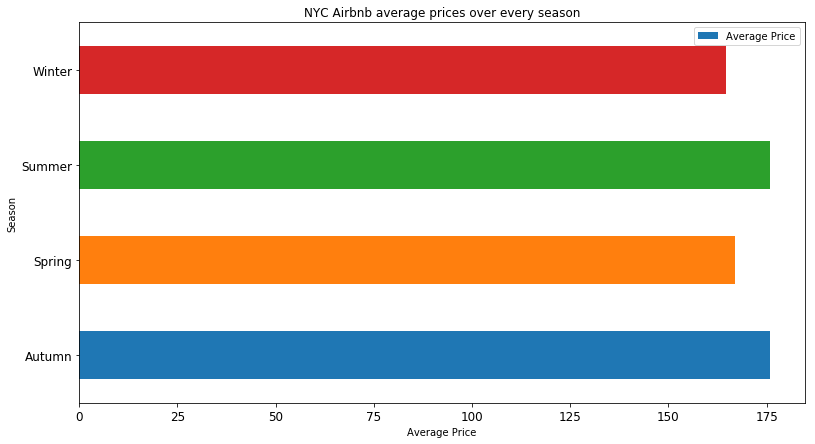

In [35]:
seasonDF.plot(x='Season', 
              y='Average Price', 
              kind='barh',
              figsize =(13,7),
              fontsize=12,
              title = "NYC Airbnb average prices over every season" 
             );

plt.xlabel('Average Price')

Text(0.5,0,'Average Price')

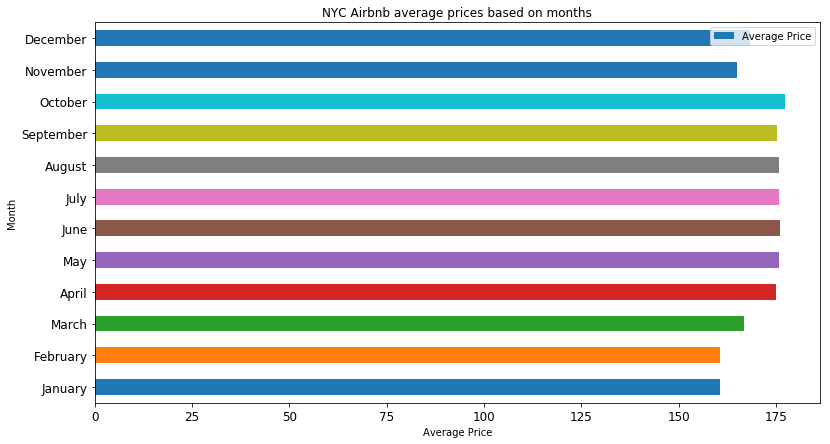

In [38]:
monthDF.plot(x='Month', 
              y='Average Price', 
              kind='barh',
              figsize =(13,7),
              fontsize=12,
              title = "NYC Airbnb average prices based on months" 
             );

plt.xlabel('Average Price')    

Text(0.5,0,'Average Price')

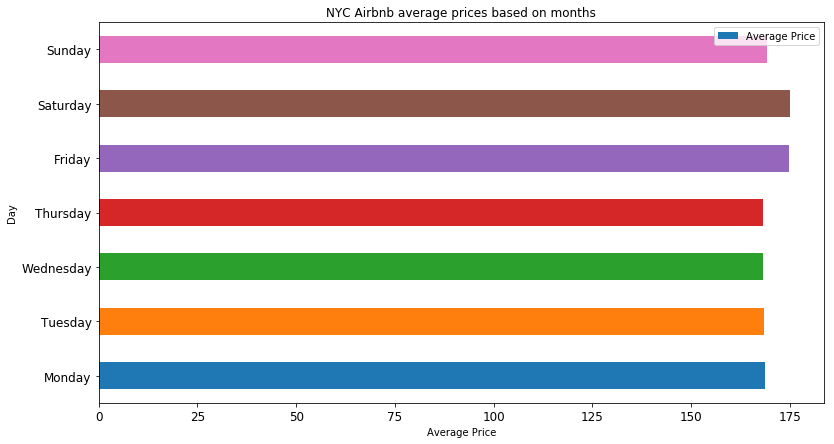

In [39]:
dayDF.plot(x='Day', 
              y='Average Price', 
              kind='barh',
              figsize =(13,7),
              fontsize=12,
              title = "NYC Airbnb average prices based on months" 
             );

plt.xlabel('Average Price')  

Text(0.5,0,'Average Price')

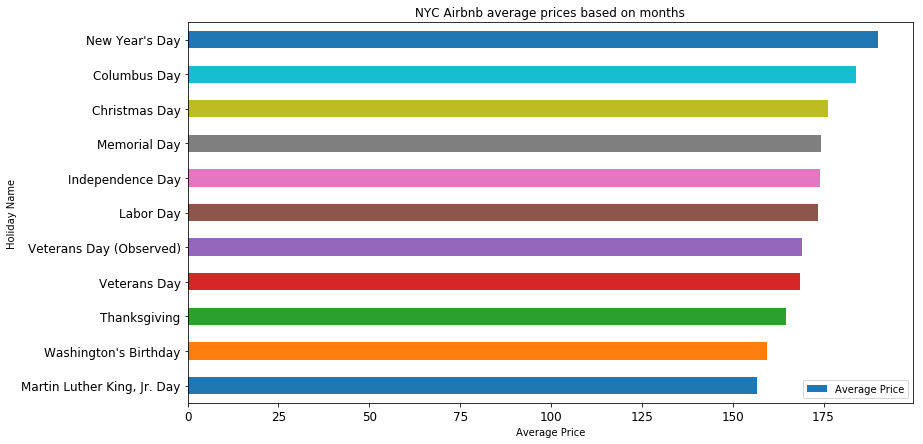

In [44]:
holidayDf.plot(x='Holiday Name', 
              y='Average Price', 
              kind='barh',
              figsize =(13,7),
              fontsize=12,
              title = "NYC Airbnb average prices based on months" 
             );

plt.xlabel('Average Price') 

In [52]:
calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day,Season,Holiday,Holiday Name,season_num,day_num
0,2515,2018-10-01,t,99.0,2018,10,01,Monday,Autumn,False,None,3,1
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday,Autumn,False,None,3,7
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday,Autumn,False,None,3,6
3,2515,2018-09-28,t,99.0,2018,09,28,Friday,Autumn,False,None,3,5
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday,Autumn,False,None,3,4


In [54]:
split_data= calendarDetailDF.drop(['date', 'available', 'price','Year','Season','Date','Day','Holiday','Holiday Name'],axis=1)
# print(split_data)
train1,test1,train2,test2=cross_validation.train_test_split(split_data, calendarDetailDF.price, test_size=0.4,train_size = 0.6,random_state=13)
print (train1)

          listing_id Month  season_num  day_num
13473640    18972181    09           3        6
5777054      8609750    09           3        2
4577208      6822457    05           2        4
16003112    21054177    02           1        6
971105        852709    01           4        5
4938303      7348959    02           1        7
12073047    17268185    11           4        2
1104452      1023181    11           4        3
648761        567281    02           1        6
10903086    15917519    11           4        7
3012668      4325329    06           2        2
7136280     10186688    11           4        1
9006619     13495558    01           4        3
13562272    19053928    11           4        6
12790499    18238083    09           3        7
7008226     10052587    12           4        1
5426608      8028382    04           1        3
5354346      7916375    04           1        7
2047883      2552938    11           4        2
4530534      6765697    03           1  

In [58]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(train1, train2)
predictions = linear_reg.predict(test1)
print(test1)
print(predictions)

          listing_id Month  season_num  day_num
10056803    14778622    05           2        3
2049182      2557018    07           2        6
2662873      3801007    03           1        7
14557450    19909222    04           1        1
4759522      7070947    12           4        1
1668732      1970177    11           4        6
10494833    15390431    10           3        6
7520870     11096888    07           2        6
16081195    21111574    09           3        4
10474558    15359284    01           4        1
5938297      8860450    05           2        7
11891101    16954330    01           4        6
10161132    14919238    12           4        7
10175780    14943439    10           3        4
3874978      5660615    04           1        1
10245726    15040421    03           1        1
2096400      2665579    01           4        6
504207        417685    02           1        5
15820169    20941086    10           3        5
13365883    18869692    11           4  

In [59]:
linear_reg_error = metrics.median_absolute_error(test2, linear_reg.predict(test1))
print ("Linear Regression: " + str(linear_reg_error))

Linear Regression: 83.3726500297305
